# Use splitfolders to Create Train, Validation and Test Datasets

In [ ]:
!pip install split-folders

In [ ]:
# Import the splitfolders library for dataset splitting
import splitfolders

# Define the input directory containing the original dataset and the output directory for the split datasets
# The dataset will be split into training, validation, and test sets using the specified ratios
input_directory = "C:/art/pure_pp_2/"
output_directory = "C:/seven/"

# The code below will automatically split the dataset in the input_directory into training, validation, and test sets
# according to the specified ratios and save them in the output_directory.
splitfolders.ratio(input_directory, output=output_directory, seed=1234, ratio=(0.8, 0.1, 0.1))

<br>

# Model Training : ResNetRS50 with Data Augmentation

In [22]:
import tensorflow as tf
from tensorflow.keras.optimizers import Lion
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_rs import ResNetRS50
from tensorflow.keras.applications.resnet_rs import preprocess_input
import pickle 
import numpy as np
import matplotlib.pyplot as plt

# Define paths for the training, validation, and test datasets
train_path = "c:/seven/train"
validation_path = "c:/seven/val"
test_path = "c:/seven/test"

# Define data augmentation configurations for training, validation, and testing
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      rotation_range=90,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing
training_generator = training_datagen.flow_from_directory(train_path,
                                                          batch_size=32,
                                                          shuffle=True,
                                                          target_size=(224, 224),
                                                          class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              target_size=(224, 224),
                                                              class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  target_size=(224, 224),
                                                  class_mode='categorical')

# Display class labels
training_generator.class_indices.keys()
validation_generator.class_indices.keys()
test_generator.class_indices.keys()

# Define image shape and create the ResNetRS50 base model
img_shape = (224, 224, 3)
ResNetRS50_model = ResNetRS50(input_shape=img_shape, include_top=False, weights='imagenet')
ResNetRS50_model.trainable = False

# Create the complete model architecture by adding layers to the base model
model = Sequential([
    ResNetRS50_model,
    GlobalAveragePooling2D(),
    Dense(10240, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the model with Lion optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Lion(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.99,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name='Lion',
    ), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for dynamic learning rate adjustment and early stopping
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# Train the model using the data generators and callbacks
history = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks=[rlr, es])

Found 14340 images belonging to 7 classes.
Found 1789 images belonging to 7 classes.
Found 1793 images belonging to 7 classes.
Epoch 1/100
449/449 [==============================] - 1050s 2s/step - loss: 0.8126 - accuracy: 0.6944 - val_loss: 0.6477 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - 959s 2s/step - loss: 0.5799 - accuracy: 0.7819 - val_loss: 0.6503 - val_accuracy: 0.7574 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - 965s 2s/step - loss: 0.5206 - accuracy: 0.8055 - val_loss: 0.6391 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============================] - 953s 2s/step - loss: 0.4594 - accuracy: 0.8209 - val_loss: 0.5900 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 5/100
449/449 [==============================] - 920s 2s/step - loss: 0.4294 - accuracy: 0.8401 - val_loss: 0.5568 - val_accuracy: 0.7865 - lr: 1.0000e-04
Epoch 6/100
449/449 [==============================] - 927s 2s/step

## Model Evaluation with Test Dataset

In [23]:
# Evaluate the model on the test dataset and print loss and accuracy
score = model.evaluate(test_generator)
print('loss : ', score[0])
print('accuracy : ', score[1])

57/57 [==============================] - 97s 2s/step - loss: 0.5819 - accuracy: 0.8009
loss :  0.5818535685539246
accuracy :  0.8008923530578613


## Saving the model & history

In [24]:
# Save the model
model.save("C:/seven/model_resnetrs50_lion_dense10240.h5")

In [25]:
import pickle

# Save the history from model.fit
file = open("C:/seven/history.txt","wb") 
pickle.dump(history, file) 
file.close()    

## Loading the model & history

In [7]:
from tensorflow.keras.models import load_model

model = load_model('C:/seven/model_resnetrs50_lion_dense10240.h5')

In [1]:
import pickle

file = open("C:/seven/history.txt","rb") 
history = pickle.load(file) 
file.close()  

## Line Graph of Training Loss & Validation Loss

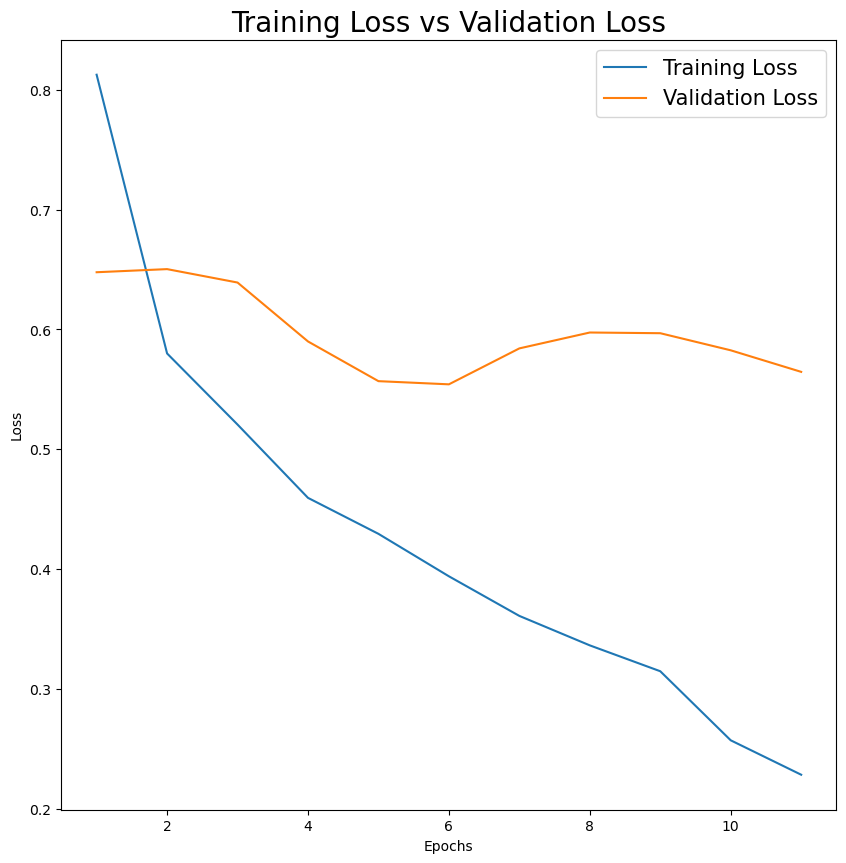

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of epochs
epochs = 11

# Plotting the training loss and validation loss over epochs
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, epochs+1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, epochs+1), history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=15)
plt.show()

## Line Graph of Training Accuracy & Validation Accuracy

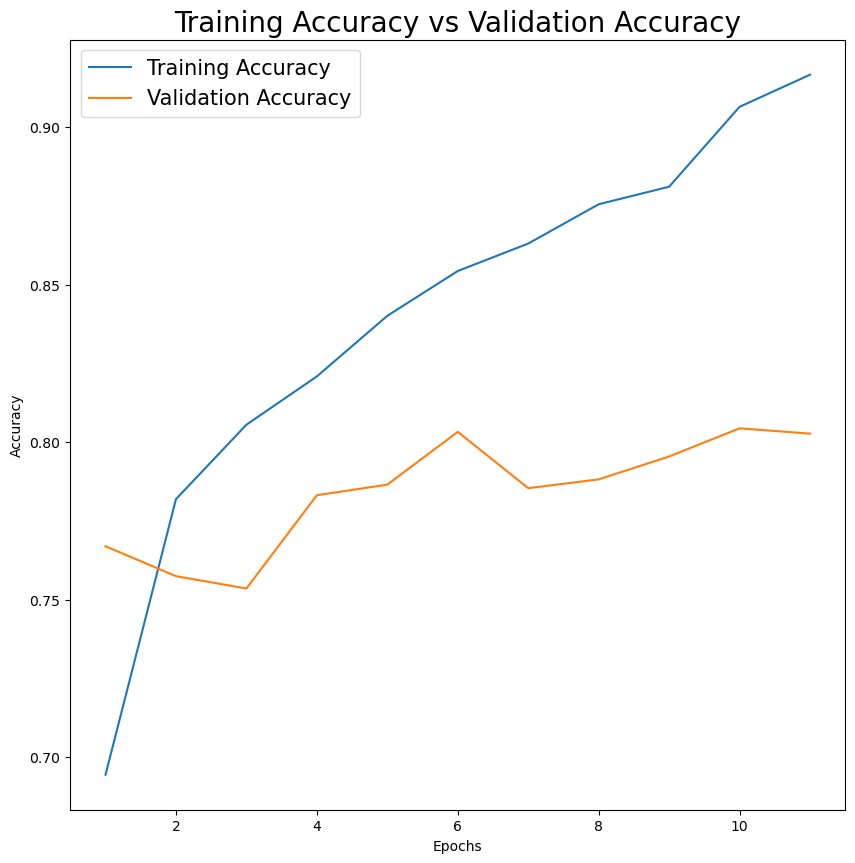

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of epochs
epochs = 11

# Plotting the training accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, epochs+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, epochs+1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy', fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(fontsize=15)
plt.show()

<br>